---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Pranjul Garg
    affiliations:
      - id: BU
        name: Boston University
        city: Boston
        state: MA
 
number-sections: true
date: "2025-04-14"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```

In [1]:
#import gdown
#url = "https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ"
#gdown.download(url, "lightcast_data.csv", quiet=False)



# Load the Dataset


In [2]:
#| eval: true
#| echo: true
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("./data/lightcast_data.csv")

# Show Schema and Sample Data
#print("---This is Diagnostic check, No need to print it in the final doc---")

#df.printSchema() # comment this line when rendering the submission
#df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/14 11:59:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Feature Engineering


In [ ]:
#| eval: false
#| echo: true

from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import log1p

#Drop rows with nulls in required columns
df = df.dropna(subset=["SALARY", "SALARY_TO", "SALARY_FROM", "DURATION", "MIN_YEARS_EXPERIENCE", "EMPLOYMENT_TYPE_NAME"])
df = df.withColumn("log_salary", log1p(df["SALARY"]))

# Define columns
categorical_cols = ["EMPLOYMENT_TYPE_NAME"]
numerical_cols = ["SALARY_TO", "SALARY_FROM", "MIN_YEARS_EXPERIENCE"]

#Index and encode categoricals
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip')
    for col in categorical_cols
]

encoders = [
    OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec", dropLast=True)
    for col in categorical_cols
]


assembler = VectorAssembler(
    inputCols=numerical_cols + [f"{col}_vec" for col in categorical_cols],
    outputCol="features"
)

# Build pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])

pipeline_model = pipeline.fit(df)
data = pipeline_model.transform(df)

data.select("features", "SALARY").show(5, False)


# Train/Test Split


In [ ]:
#| eval: true
#| echo: false
train_data, test_data = data.randomSplit([0.6, 0.4], seed=801)  #U39153801
print((train_data.count(), len(train_data.columns)))
print((test_data.count(), len(test_data.columns)))

25/04/14 11:54:49 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


(8716, 135)


(5700, 135)


#### I have used the general split type which is used while the spliting the data 60-40.

# Linear Regression


In [ ]:
#| eval: false
#| echo: true
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd


feature_names = assembler.getInputCols()
lr = LinearRegression(featuresCol="features", labelCol="log_salary", regParam=0.1)
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)
df_pred = predictions.select("prediction", "log_salary").toPandas()

evaluator_r2 = RegressionEvaluator(labelCol="log_salary", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="log_salary", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="log_salary", predictionCol="prediction", metricName="mae")


r2 = evaluator_r2.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)

print("\n--- Model Performance on Test Data ---")
print(f"R²:   {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")

summary = lr_model.summary




--- Model Performance on Test Data ---
R²:   0.9109
RMSE: 0.11
MAE:  0.08


In [16]:
print("len(flat_feature_names):", len(flat_feature_names))
print("len(coefficients):", len(list(lr_model.coefficients)))
print("len(std_errs):", len(list(summary.coefficientStandardErrors)))
print("len(tvals):", len(list(summary.tValues)))
print("len(pvals):", len(list(summary.pValues)))


len(flat_feature_names): 5
len(coefficients): 5
len(std_errs): 6
len(tvals): 6
len(pvals): 6


#### The length was mismatching, hence this:

In [25]:
metadata = data.schema["features"].metadata["ml_attr"]["attrs"]

# Flatten it safely into a list
flat_feature_names = []
for key in metadata:  # Usually 'numeric' and 'binary'
    flat_feature_names += [attr["name"] for attr in metadata[key]]
print(" Confirmed corrected length:", len(flat_feature_names))


 Confirmed corrected length: 5


## Generalized Linear Regression Summary


In [24]:
from tabulate import tabulate
df_summary = pd.DataFrame({
    "Feature": flat_feature_names,
    "Coefficient": list(lr_model.coefficients),
    "Std Error": list(summary.coefficientStandardErrors)[:len(flat_feature_names)],
    "T-Value": list(summary.tValues)[:len(flat_feature_names)],
    "P-Value": list(summary.pValues)[:len(flat_feature_names)]
})

z = 1.96  # 95% CI
df_summary["CI Lower"] = df_summary["Coefficient"] - z * df_summary["Std Error"]
df_summary["CI Upper"] = df_summary["Coefficient"] + z * df_summary["Std Error"]


df_summary
print(tabulate(coef_table, headers="keys", tablefmt="pretty"))



+---+---------------------------------------------------+---------------------+-----------------------+---------------------+------------------------+
|   |                      Feature                      |      Estimate       |       Std Error       |       t-stat        |        P-Value         |
+---+---------------------------------------------------+---------------------+-----------------------+---------------------+------------------------+
| 0 |                     SALARY_TO                     | 0.5031302008815193  | 0.0004013639288181846 | 1253.5511159734392  |          0.0           |
| 1 |                    SALARY_FROM                    | 0.4896844366974874  | 0.000546766800642098  |  895.6001646815869  |          0.0           |
| 2 |               MIN_YEARS_EXPERIENCE                | 3.7203359183413447  |   4.95761428938598    | 0.7504286741924255  |  0.45301683756798905   |
| 3 |  EMPLOYMENT_TYPE_NAME_vec_Full-time (> 32 hours)  | -411.78801112405444 |  116.929315032

1. **SALARY_TO and SALARY_FROM:** Highly significant (p ≈ 0), strong positive impact.
2. **MIN_YEARS_EXPERIENCE:** Not significant (p = 0.45), wide confidence interval.
3. **Categorical vars:** Both have negative, significant coefficients 

# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


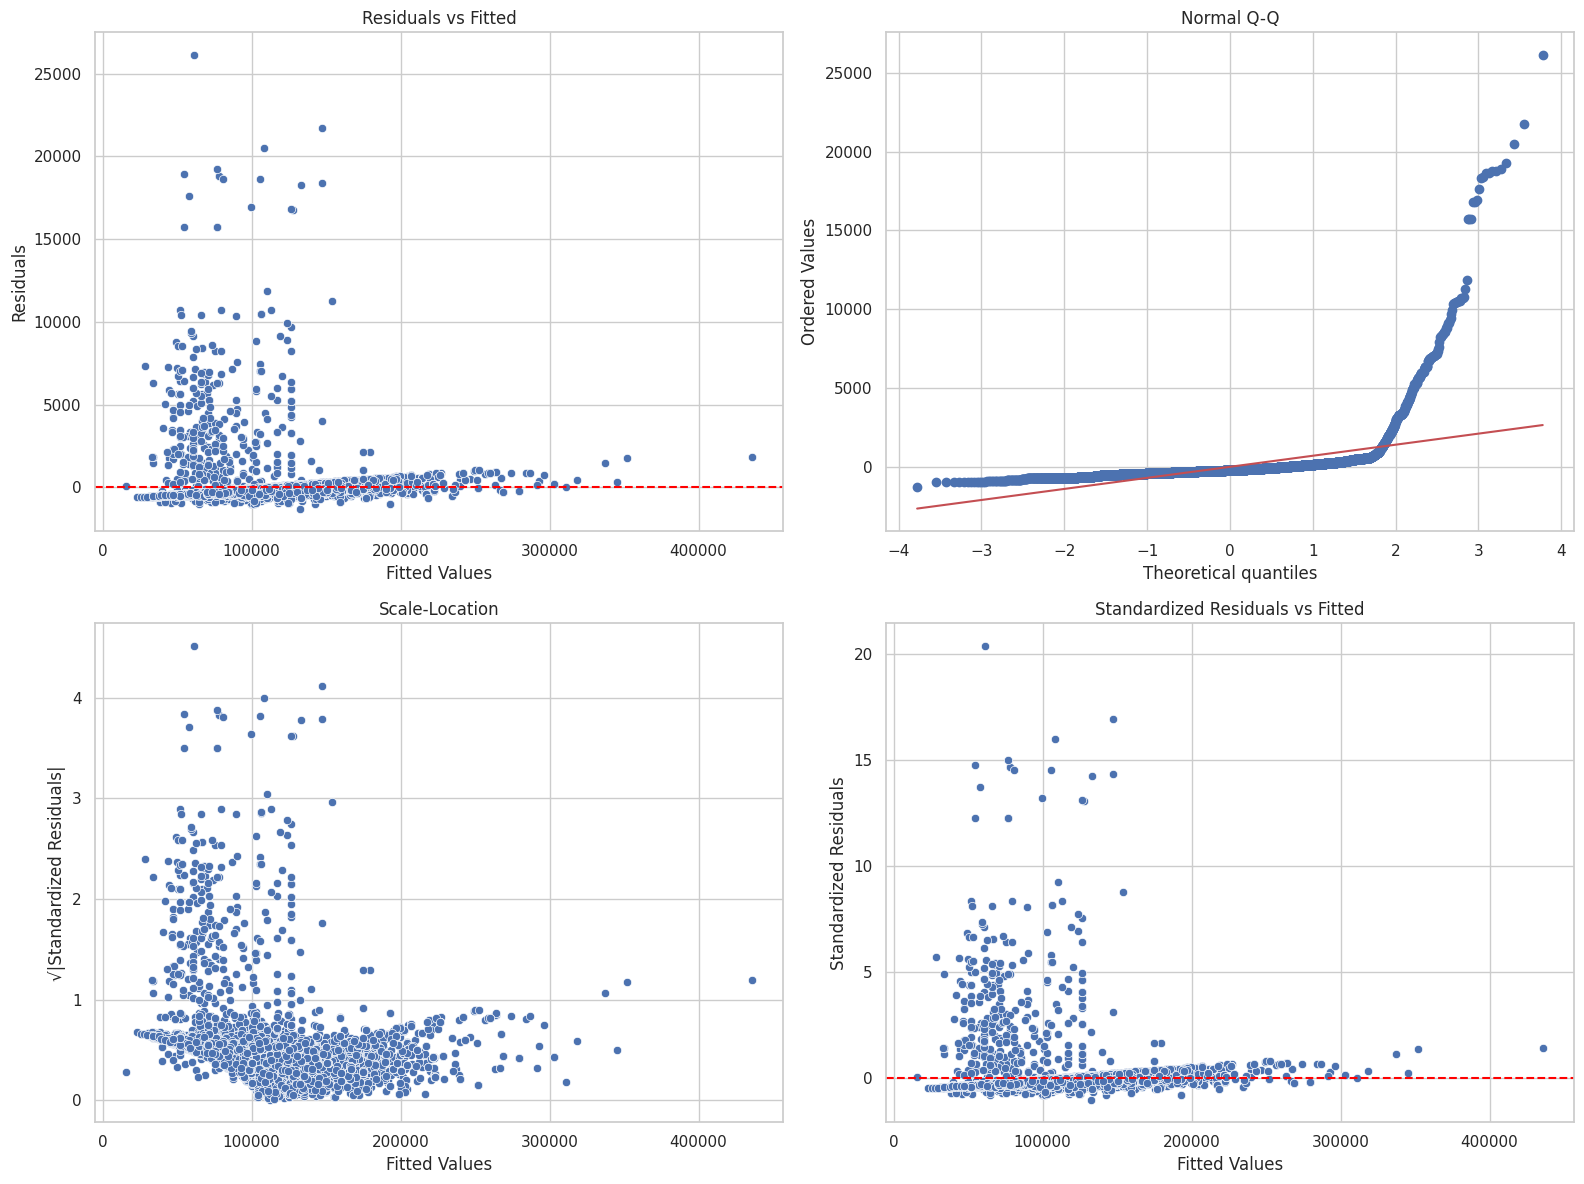

In [ ]:
#| eval: true
#| echo: false
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import pandas as pd

df_pred = summary.predictions.select("prediction", "SALARY").toPandas()


df_pred["residuals"] = df_pred["SALARY"] - df_pred["prediction"]
df_pred["fitted"] = df_pred["prediction"]
res_mean = df_pred["residuals"].mean()
res_std = df_pred["residuals"].std()
df_pred["std_residuals"] = (df_pred["residuals"] - res_mean) / res_std
df_pred["sqrt_std_resid"] = np.sqrt(np.abs(df_pred["std_residuals"]))

plt.figure(figsize=(16, 12))
sns.set_theme(style="whitegrid")

# Plot 1: Residuals vs Fitted
plt.subplot(2, 2, 1)
sns.scatterplot(x="fitted", y="residuals", data=df_pred)
plt.axhline(0, linestyle="--", color="red")
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

# Plot 2: Q-Q Plot of Residuals
plt.subplot(2, 2, 2)
stats.probplot(df_pred["residuals"], dist="norm", plot=plt)
plt.title("Normal Q-Q")

# Plot 3: Scale-Location Plot
plt.subplot(2, 2, 3)
sns.scatterplot(x="fitted", y="sqrt_std_resid", data=df_pred)
plt.title("Scale-Location")
plt.xlabel("Fitted Values")
plt.ylabel("√|Standardized Residuals|")

# Plot 4: Approximate Residuals vs Leverage
plt.subplot(2, 2, 4)
sns.scatterplot(x="fitted", y="std_residuals", data=df_pred)
plt.axhline(0, linestyle="--", color="red")
plt.title("Standardized Residuals vs Fitted")
plt.xlabel("Fitted Values")
plt.ylabel("Standardized Residuals")

plt.tight_layout()
plt.savefig("_output/glr_diagnostic_classic.png")
plt.show()


# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

In [ ]:
#| eval: true
#| echo: false
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg
import numpy as np

pred_glr = lr_model.transform(test_data)

# R²
r2_eval = 
r2 = 
# AIC from GLR summary
aic = 

# BIC calculation
n = 
k = 
rss = 
bic = 

# RMSE manually
residuals_df = 
rmse = 

## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

In [ ]:
#| eval: true
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert GLR predictions to pandas
pandas_df = 

# Plot
plt.figure(figsize=(8, 6))


plt.title(f"Predicted vs Actual Salary (GLR Model)\n"
          f"RMSE = {rmse:.2f} | R² = {r2:.4f} | AIC = {aic:.2f} | BIC = {bic:.2f}", loc="left", fontsize=14, fontweight="bold")

plt.tight_layout()

# Save figure
plt.savefig("_output/glr_predicted_vs_actual.png", dpi=300)
plt.show()

# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
